In [2]:
import sys
from pathlib import Path

# custom imports

PROJECT_ROOT = Path(__file__).resolve().parent.parent.parent if "__file__" in locals() else Path("../../..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.eval.evaluation.loader import load_test_data_v2, load_model
from src.eval.evaluation.style import apply_shap_style, get_model_style, save_plot, SHAP_RED, SHAP_BLUE

apply_shap_style()


In [5]:

# --- KONFIGURATION ---
PATH = Path(
    "/Users/robin/PycharmProjects/Masterarbeit/remote/remote_db_files/asinh1-reg-300-mae/asinh1-reg-300-mae.db")  # Pfad zu deiner .db Datei anpassen
DB_PATH = f"sqlite:///{PATH}"  # Pfad zu deiner .db Datei anpassen
MODELS = ["Lasso_LargeScale", "EBM", "CatBoostGPU", "RandomForest", "MLP"]

✅ Grafik gespeichert in: figures/hpo_optimization_dashboard


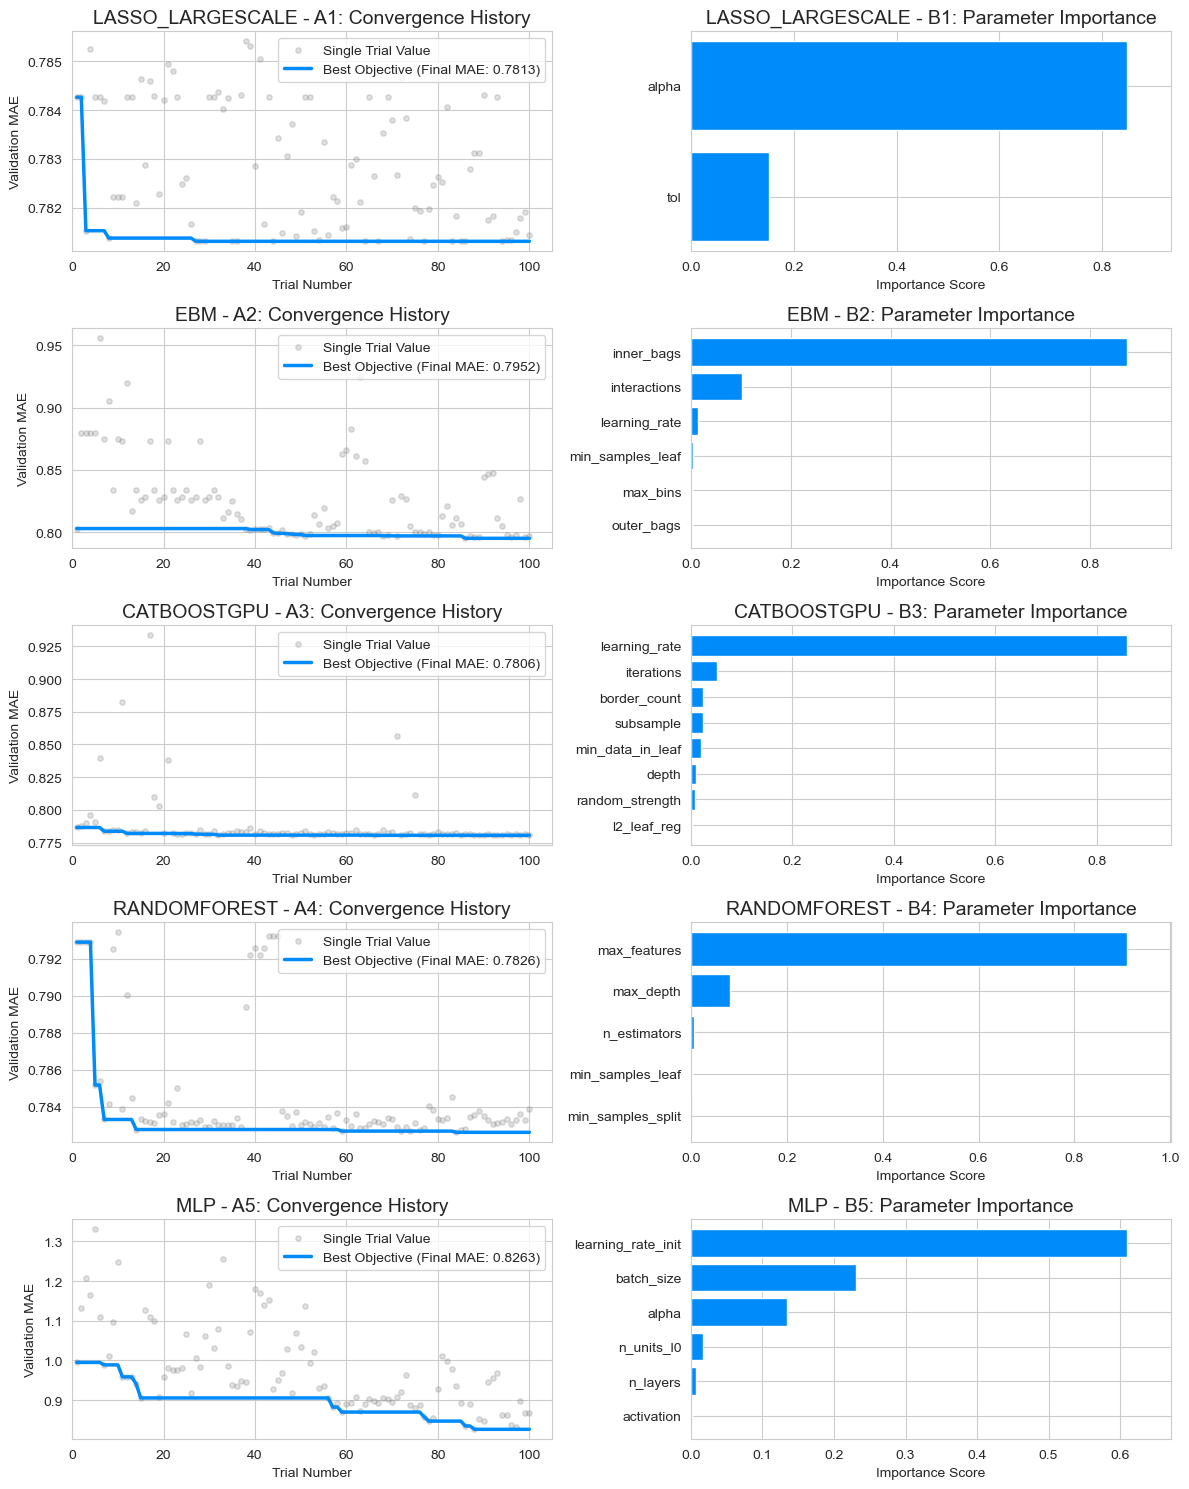

In [6]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def plot_hpo_appendix_dashboard(db_path, models, save_name="hpo_optimization_dashboard"):
    """
    Erstellt ein n x 2 Dashboard zur Dokumentation der HPO (Anhang):
    Spalte 1: Convergence History (mit finalem Score in der Legende)
    Spalte 2: Parameter Importance
    """
    nrows = len(models)
    fig, axes = plt.subplots(nrows, 2, figsize=(12, 3 * nrows))

    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, model_key in enumerate(models):
        try:
            summaries = optuna.get_all_study_summaries(storage=db_path)
            study_name = next((s.study_name for s in summaries if model_key.lower() in s.study_name.lower()), None)

            if not study_name:
                continue

            study = optuna.load_study(study_name=study_name, storage=db_path)

            # --- SPALTE 1: Convergence Plot (Trials 1-100) ---
            ax_conv = axes[i, 0]
            all_trials = [t.value for t in study.trials if
                          t.state == optuna.trial.TrialState.COMPLETE and t.value is not None]
            trials = all_trials[:100]

            if trials:
                best_so_far = pd.Series(trials).expanding().min()
                final_score = best_so_far.iloc[-1]  # Der beste Wert nach 100 Trials

                ax_conv.scatter(range(1, len(trials) + 1), trials, color='gray', s=15, alpha=0.25,
                                label='Single Trial Value')
                # Hier nehmen wir den finalen Score in das Label auf
                ax_conv.plot(range(1, len(trials) + 1), best_so_far, color=SHAP_BLUE, linewidth=2.5,
                             label=f'Best Objective (Final MAE: {final_score:.4f})')

                ax_conv.set_title(f"{model_key.upper()} - A{i + 1}: Convergence History", fontsize=14)
                ax_conv.set_xlabel("Trial Number")
                ax_conv.set_ylabel("Validation MAE")
                ax_conv.set_xlim(0, 105)
                # Legende für jedes Panel einzeln (wichtig für den finalen Score)
                ax_conv.legend(loc='upper right', frameon=True, fontsize=10)

            # --- SPALTE 2: Parameter Importance ---
            ax_imp = axes[i, 1]
            try:
                importances = optuna.importance.get_param_importances(study)
                if importances:
                    imp_df = pd.DataFrame(list(importances.items()), columns=['param', 'value']).sort_values(by='value')
                    ax_imp.barh(imp_df['param'], imp_df['value'], color=SHAP_BLUE)
                    ax_imp.set_title(f"{model_key.upper()} - B{i + 1}: Parameter Importance", fontsize=14, )
                    ax_imp.set_xlabel("Importance Score")
                    ax_imp.set_xlim(0, max(imp_df['value']) * 1.1)
                else:
                    ax_imp.text(0.5, 0.5, "Insufficient data", ha='center')
            except Exception:
                ax_imp.text(0.5, 0.5, "Importance calculation failed", ha='center')

        except Exception as e:
            print(f"Fehler bei Modell {model_key}: {e}")

    plt.tight_layout()
    if save_name:
        save_plot(fig, "hpo_optimization_dashboard")
    plt.show()


plot_hpo_appendix_dashboard(DB_PATH, ["Lasso_LargeScale", "EBM", "CatBoostGPU", "RandomForest", "MLP"],
                            save_name="hpo_optimization_dashboard")

In [7]:
import optuna
import pandas as pd


def generate_hpo_summary_csv(db_path, models, output_file="hpo_summary_table.csv"):
    """
    Erstellt eine zusammenfassende CSV-Tabelle für den Anhang/Ergebnisteil.
    Spalten: Modell, Parameter, Search Space, Optimal Value
    """
    table_rows = []

    for model_key in models:
        try:
            # Studie laden
            summaries = optuna.get_all_study_summaries(storage=db_path)
            study_name = next((s.study_name for s in summaries if model_key.lower() in s.study_name.lower()), None)

            if not study_name:
                print(f"Warnung: Studie für {model_key} nicht gefunden.")
                continue

            study = optuna.load_study(study_name=study_name, storage=db_path)
            best_params = study.best_params

            # Wir brauchen einen erfolgreichen Trial, um die Suchraum-Definition (Distributions) zu lesen
            first_trial = next((t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE), None)

            if first_trial:
                distributions = first_trial.distributions

                for param_name, value in best_params.items():
                    dist = distributions[param_name]

                    # Formatierung des Search Space Strings
                    if hasattr(dist, "low"):
                        space_str = f"[{dist.low}, {dist.high}]"
                        if getattr(dist, "log", False):
                            space_str += " (log)"
                    elif hasattr(dist, "choices"):
                        space_str = f"{dist.choices}"
                    else:
                        space_str = "N/A"

                    # Zeile zur Tabelle hinzufügen
                    table_rows.append({
                        "modell": model_key.upper(),
                        "parameter": param_name,
                        "search space": space_str,
                        "optimal value": f"{value:.5f}" if isinstance(value, float) else value
                    })

        except Exception as e:
            print(f"Fehler bei Modell {model_key}: {e}")

    # In DataFrame umwandeln und speichern
    df = pd.DataFrame(table_rows)
    df.to_csv(output_file, index=False, sep=";")  # Semikolon für besseren Excel-Import
    print(f"Tabelle erfolgreich als {output_file} gespeichert.")
    return df


# Beispielaufruf:
summary_df = generate_hpo_summary_csv(DB_PATH, MODELS)

Tabelle erfolgreich als hpo_summary_table.csv gespeichert.
